In [1]:
import pandas as pd
import numpy as np
import os 

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
!pwd

/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations


In [3]:
!ls

Download_station_data.ipynb Weather_stations
Weather_station_data.ipynb


#### 1. Load our data and perform any basic cleaning and/or EDA.¶

In [4]:
station_names = ['Aberporth', 'Armagh', 'Ballypatrick Forest', 'Bradford', 'Braemar', 'Camborne', 'Cambridge NIAB', 'Cardiff Bute Park',
 'Chivenor', 'Cwmystwyth', 'Dunstaffnage', 'Durham', 'Eastbourne', 'Eskdalemuir', 'Heathrow', 'Hurn', 'Lerwick',
 'Leuchars', 'Lowestoft', 'Manston', 'Nairn', 'Newton Rigg', 'Oxford', 'Paisley', 'Ringway', 'Ross-on-Wye',
 'Shawbury', 'Sheffield', 'Southampton', 'Stornoway Airport', 'Sutton Bonington', 'Tiree', 'Valley',
 'Waddington', 'Whitby', 'Wick Airport', 'Yeovilton']

In [5]:
lower_station_names = []
for i in station_names:
    lower_station_names.append(i.lower().replace(' ','_').replace('-','_'))

In [6]:
def data_clean(station_name):
    station_name = pd.read_excel('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/Weather_stations/{}.xlsx'.format(station_name))
    
    station_name = station_name.iloc[1:,:-1] # get rid of useless row and column, 去除多余行，列
    # 这里有一个例外 Yeovilton 需要 station_name.iloc[1:,:] 这样slice 
    
    col_names = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun',
            'station', 'lat', 'lon'] # temperatre units: degC, rainfall units: mm, sun units: days
    station_name.columns = col_names # replace column names with col_names, 替换列名成 col_names
    
    # fill in station, lat and lon with its value, 给车站，经纬度填上唯一值
    station_name['station']= station_name.iloc[0, 7].lower().replace('-', '_').replace(' ','_')
    station_name['lat'] = station_name.iloc[0,8]
    station_name['lon'] = station_name.iloc[0,9]
    
    # replace --- with 0
    station_name = station_name.replace('---', 0)
    station_name = station_name.replace('--- #', 0)

    # fillna with 0s, 将所有NaN替换成 0
    station_name.fillna(0, inplace=True)
    
    # tidy all entries and unify types, 消除非数字字符，改type
    
    station_name['sun'] = station_name['sun'].astype(str)
    station_name['sun'] = station_name['sun'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['tmax'] = station_name['tmax'].astype(str)
    station_name['tmax'] = station_name['tmax'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['tmin'] = station_name['tmin'].astype(str)
    station_name['tmin'] = station_name['tmin'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['rain'] = station_name['rain'].astype(str)
    station_name['rain'] = station_name['rain'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['af'] = station_name['af'].astype(str)
    station_name['af'] = station_name['af'].str.extract(r'(\d+)').astype('float')

    
    # fillna with 0s, 将所有NaN替换成 0
    station_name = station_name.fillna(0)
    
    return station_name

In [7]:
def yeovilton_clean(station_name):
    station_name = pd.read_excel('/Users/paxton615/Github_Personal/Notes/Notes/Weather_stations/Weather_stations/{}.xlsx'.format(station_name))
    
    station_name = station_name.iloc[1:,:] # get rid of useless row and column, 去除多余行，列
    # 这里有一个例外 Yeovilton 需要 station_name.iloc[1:,:] 这样slice 
    
    col_names = ['year', 'month', 'tmax', 'tmin', 'af', 'rain', 'sun',
            'station', 'lat', 'lon'] # temperatre units: degC, rainfall units: mm, sun units: days
    station_name.columns = col_names # replace column names with col_names, 替换列名成 col_names
    
    # fill in station, lat and lon with its value, 给车站，经纬度填上唯一值
    station_name['station']= station_name.iloc[0, 7].lower().replace('-', '_').replace(' ','_')
    station_name['lat'] = station_name.iloc[0,8]
    station_name['lon'] = station_name.iloc[0,9]
    
    # replace --- with 0
    station_name = station_name.replace('---', 0)
    station_name = station_name.replace('--- #', 0)

    # fillna with 0s, 将所有NaN替换成 0
    station_name.fillna(0, inplace=True)
    
    # tidy all entries and unify types, 消除非数字字符，改type
    
    station_name['sun'] = station_name['sun'].astype(str)
    station_name['sun'] = station_name['sun'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['tmax'] = station_name['tmax'].astype(str)
    station_name['tmax'] = station_name['tmax'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['tmin'] = station_name['tmin'].astype(str)
    station_name['tmin'] = station_name['tmin'].str.extract(r'(-?\d+.\d+)').astype('float')

    station_name['rain'] = station_name['rain'].astype(str)
    station_name['rain'] = station_name['rain'].str.extract(r'(\d+.\d+)').astype('float')

    station_name['af'] = station_name['af'].astype(str)
    station_name['af'] = station_name['af'].str.extract(r'(\d+)').astype('float')

    
    # fillna with 0s, 将所有NaN替换成 0
    station_name = station_name.fillna(0)
    
    return station_name

In [8]:
aberporth = data_clean('Aberporth')
armagh = data_clean('Armagh')
ballypatrick_forest= data_clean('Ballypatrick Forest')
bradford = data_clean('Bradford')
braemar = data_clean('Braemar')
camborne = data_clean('Camborne')
cambridge_niab = data_clean('Cambridge NIAB')
cardiff_bute_park = data_clean('Cardiff Bute Park')
chivenor = data_clean('Chivenor')
cwmystwyth = data_clean('Cwmystwyth')
dunstaffnage = data_clean('Dunstaffnage')
durham = data_clean('Durham')
eastbourne = data_clean('Eastbourne')
eskdalemuir = data_clean('Eskdalemuir')
heathrow = data_clean('Heathrow')
hurn = data_clean('Hurn')
lerwick = data_clean('Lerwick')
leuchars = data_clean('Leuchars')
lowestoft = data_clean('Lowestoft')
manston = data_clean('Manston')
nairn = data_clean('Nairn')
newton_rigg = data_clean('Newton Rigg')
oxford = data_clean('Oxford')
paisley = data_clean('Paisley')
ringway = data_clean('Ringway') # last year is 2004, not 2022
ross_on_wye = data_clean('Ross-on-Wye')
shawbury = data_clean('Shawbury')
sheffield = data_clean('Sheffield')
southampton = data_clean('Southampton') # last year 2000,not 2022
stornoway_airport = data_clean('Stornoway')
sutton_bonington = data_clean('Sutton Bonington')
tiree = data_clean('Tiree')
valley = data_clean('Valley')
waddington = data_clean('Waddington')
whitby = data_clean('Whitby')
wick_airport = data_clean('Wick Airport')
yeovilton = yeovilton_clean('Yeovilton') 
# for some reason, yeovilton needs function to be altered as such:
# station_name = station_name.iloc[1:,:]

In [9]:
# check the last year and month of all stations

In [10]:
uni = [aberporth, armagh, ballypatrick_forest, bradford, braemar,
      camborne, cambridge_niab, cardiff_bute_park, chivenor, 
      cwmystwyth, dunstaffnage, durham, eastbourne, eskdalemuir,
      heathrow, hurn, lerwick, leuchars, lowestoft, manston,
      nairn, newton_rigg, oxford, paisley, ringway, ross_on_wye,
      shawbury, sheffield, southampton, stornoway_airport, 
      sutton_bonington, tiree, valley, waddington, whitby,
      wick_airport, yeovilton]
len(uni)

37

In [11]:
# YEAR
# for i in uni:
#     print('{}          year:{}'.format(i.iloc[-1,7],i.iloc[-1,0]))

In [12]:
# cwmystwyth          year:2011.0
# ringway          year:2004.0
# southampton          year:2000.0  (other data's year all end at 2022)

In [13]:
# MONTH
# for i in uni:
#     print('{}          month:{}'.format(i.iloc[-1,7],i.iloc[-1,1]))

In [14]:
# ringway          month:10.0   (other data's month all end at March)
    

In [15]:
# ???
# get rid of cwmystwyth,ringway,southampton 但是我感觉，可能，也没有必要


In [16]:
# 因为发现了很多数据缺失情况，比如7月最高平均气温是0度。
# 所以决定使用 avg 平均气温, 平均降雾，降雨，阳光量作为大数据分析的标准。

In [17]:
uni[36].tail(3)

,year,month,tmax,tmin,af,rain,sun,station,lat,lon
689,2022.0,1.0,0.0,0.5,15.0,22.4,62.7,yeovilton,51.006,-2.641
690,2022.0,2.0,11.2,3.8,4.0,41.8,72.2,yeovilton,51.006,-2.641
691,2022.0,3.0,13.1,3.5,5.0,49.2,164.7,yeovilton,51.006,-2.641


In [18]:
pd.DataFrame({"station":uni[36].iloc[-1,7],
#               'all_tmx':uni[36].iloc[:,2].max(),  all_  means the highest temperature
#              'all_tmin':uni[36].iloc[:,3].min(), 
             'avg_tmx':np.round(uni[36].iloc[:,2].mean(),2), 
             'avg_tmin':np.round(uni[36].iloc[:,3].mean(),2),
              'avg_af':np.round(uni[36].iloc[:,4].mean(),2),
              'avg_rain':np.round(uni[36].iloc[:,5].mean(),2),
              'avg_sun':np.round(uni[36].iloc[:,6].mean(),2),
             'lat':uni[36].iloc[-1,8],
             'lon':uni[36].iloc[-1,9]},
             index=[1]).columns

Index(['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun',
       'lat', 'lon'],
      dtype='object')

In [19]:
vase = []
for i in uni:
    vase.append([i.iloc[-1,7],
              np.round(i.iloc[:,2].mean(),2),
               np.round(i.iloc[:,3].mean(),2),
               np.round(i.iloc[:,4].mean(),2),
               np.round(i.iloc[:,5].mean(),2),
               np.round(uni[36].iloc[:,6].mean(),2),
             i.iloc[-1,8],
             i.iloc[-1,9]])

In [20]:
data = pd.DataFrame(vase, columns = ['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun',
       'lat', 'lon'])
data.dtypes

station      object
avg_tmx     float64
avg_tmin    float64
avg_af      float64
avg_rain    float64
avg_sun     float64
lat         float64
lon         float64
dtype: object

In [21]:
data.head()

,station,avg_tmx,avg_tmin,avg_af,avg_rain,avg_sun,lat,lon
0,aberporth,12.23,7.14,1.22,76.26,83.26,52.139,-4.570
1,armagh,10.79,4.71,3.05,63.51,83.26,54.352,-6.649
2,ballypatrick_forest,10.88,5.28,2.33,60.04,83.26,55.181,-6.153
3,bradford,11.09,5.16,3.72,66.01,83.26,53.813,-1.772
4,braemar,9.23,2.43,8.64,66.70,83.26,57.006,-3.396


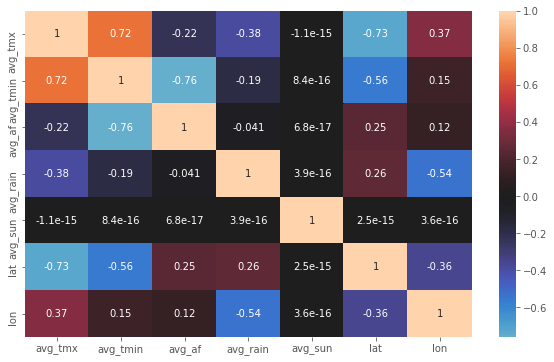

In [22]:
corrmat= data.corr()
plt.figure(figsize=(10,6))  
sns.heatmap(corrmat,annot=True,  center=0);

#### Set up an X matrix to perform clustering with DBSCAN.

In [23]:
# ['station', 'avg_tmx', 'avg_tmin', 'avg_af', 'avg_rain', 'avg_sun','lat', 'lon']

In [24]:
X = data.drop(['station','avg_sun'], axis = 1)
X.head(2)

,avg_tmx,avg_tmin,avg_af,avg_rain,lat,lon
0,12.23,7.14,1.22,76.26,52.139,-4.570
1,10.79,4.71,3.05,63.51,54.352,-6.649


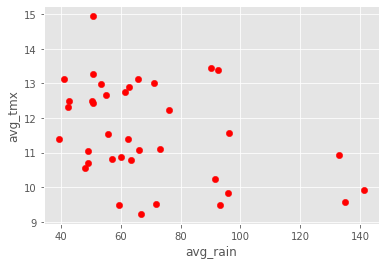

In [25]:
X.plot(x='avg_rain', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

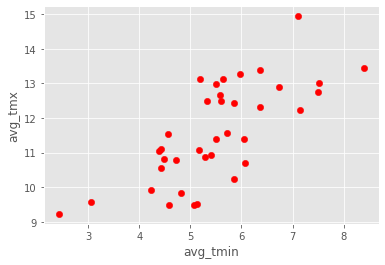

In [26]:
X.plot(x='avg_tmin', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

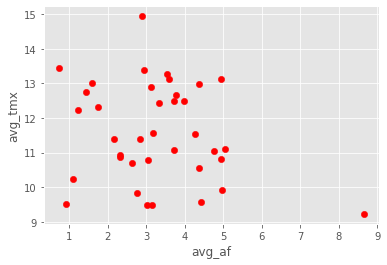

In [27]:
X.plot(x='avg_af', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

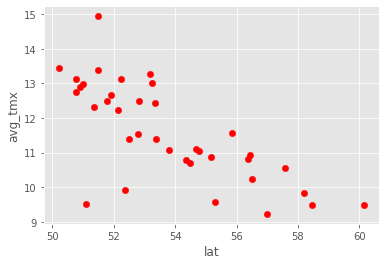

In [28]:
X.plot(x='lat', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

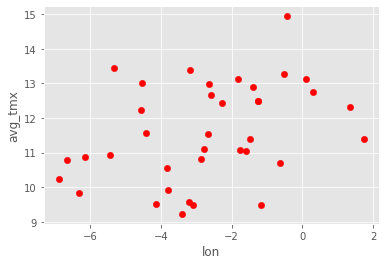

In [29]:
X.plot(x='lon', y='avg_tmx', kind='scatter', s=40, c='r')
plt.show()

#### 4. Scale data

In [30]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

#### 5. Fit a DBSCAN clusterer and check out the assigned cluster labels

In [31]:
dbscan = DBSCAN(eps=2.5, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  0  0  0 -1  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0] 

types of clusters: 2


In [32]:
dbscan = DBSCAN(eps=1.8, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  2 -1  0  2  2 -1  3  4  2  2  3  2  2  2  2  2  2  2  2  2  4
  2  2  2  2  2  1  2  1  0  2  2  2  2] 

types of clusters: 5


In [33]:
dbscan = DBSCAN(eps=1.9, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  0 -1  0  0  0 -1  2  1  0  0  2  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  1  0  1  0  0  0  0  0] 

types of clusters: 3


In [34]:
dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(Xs)

labels = dbscan.labels_
print(labels, '\n')
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print("types of clusters: {}".format(n_clusters_) )

[ 0  1  1  0 -1  0  0  0 -1  2  1  0  0  2  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  1  0  1  0  0  0  0  0] 

types of clusters: 3


#### 6. Identify core samples

In [35]:
# Extract core sample indices
print(dbscan.core_sample_indices_)

[ 0  1  2  3  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36]


In [36]:
core_samples = np.zeros_like(labels, dtype=bool)
core_samples

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [37]:
core_samples[dbscan.core_sample_indices_] = True
core_samples

array([ True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [38]:
print("Core samples")
print((core_samples * 1))

Core samples
[1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
